In [1]:
import re
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import fuzz
import numpy as np

sys.path.append(os.path.abspath(".."))

from utils.db import fetch_sanctions

In [ ]:
df = fetch_sanctions()
df.head()

In [ ]:
# Data Overview

df.info()
df.describe(include="all")
df.isnull().sum()

In [ ]:
# Sanity check for uniqueness
df['ent_num'].nunique(), df.duplicated().sum()

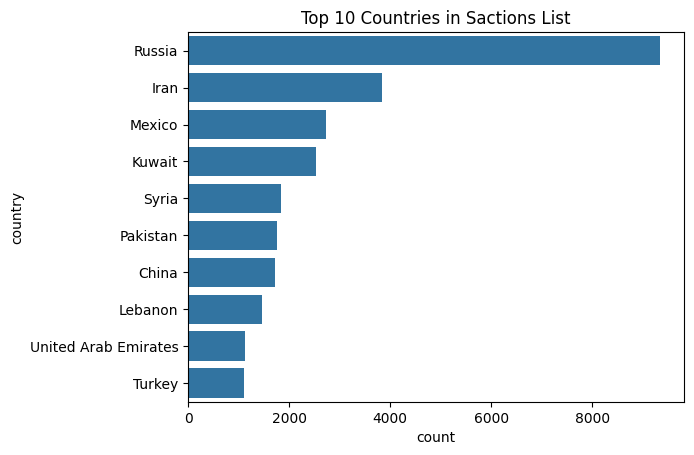

In [12]:
# Data Distribution (Exploratory Visuals)

sns.countplot(data=df, y='country', order=df['country'].value_counts().head(10).index)
plt.title("Top 10 Countries in Sactions List")
plt.show()

<Axes: title={'center': 'SDN Types Distribution'}, ylabel='sdn_type'>

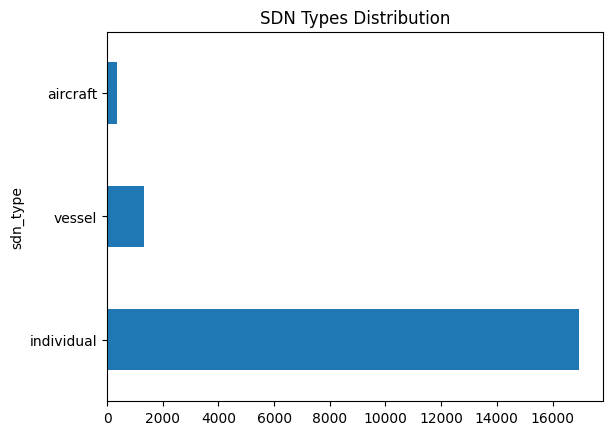

In [6]:
df['sdn_type'].value_counts().plot(kind='barh', title="SDN Types Distribution")

In [ ]:
# Data Cleaning

def standardize_name(name: str) -> str:
    if pd.isnull(name):
        return ''
    name = re.sub(r"[/-]", " ", name).upper()
    name = re.sub(r"[^A-Z\s]", "", name)
    name = re.sub(r"\s+", " ", name).strip()
    return name

df['cleaned_name'] = df['sdn_name'].apply(standardize_name)

df.head(10)

In [8]:
df.to_csv('../data/sanctions_cleaned.csv', index=False)

In [9]:
# Feature Engineering

def get_fuzz_ratio(name1: str, name2: str) -> float:
    name1 = " ".join(sorted(name1.split()))
    name2 = " ".join(sorted(name2.split()))

    try:
        return round(fuzz.ratio(name1, name2), 2)
    except:
        return 0

def get_length_difference(name1: str, name2: str) -> int:
    return abs(len(name1) - len(name2))

def get_common_token_count(name1: str, name2: str) -> int:
    return len(set(name1.split()) & set(name2.split()))
    
df['name_length'] = df['cleaned_name'].str.len()
df['word_count'] = df['cleaned_name'].str.split().apply(len)
df['has_country_in_name'] = df.apply(
    lambda row: 1 if row['country'] and row['country'].upper() in row['cleaned_name'] else 0,
    axis=1
)

# Text similarity features
reference_name = standardize_name("AEROCARIBBEAN AIRLINES")
df['fuzz_ratio_reference'] = reference_name
df['fuzz_ratio'] = df['cleaned_name'].apply(lambda x: get_fuzz_ratio(x, reference_name))
df['length_diff'] = df['cleaned_name'].apply(lambda x: get_length_difference(x, reference_name))
df['common_token_count'] = df['cleaned_name'].apply(lambda x: get_common_token_count(x, reference_name))

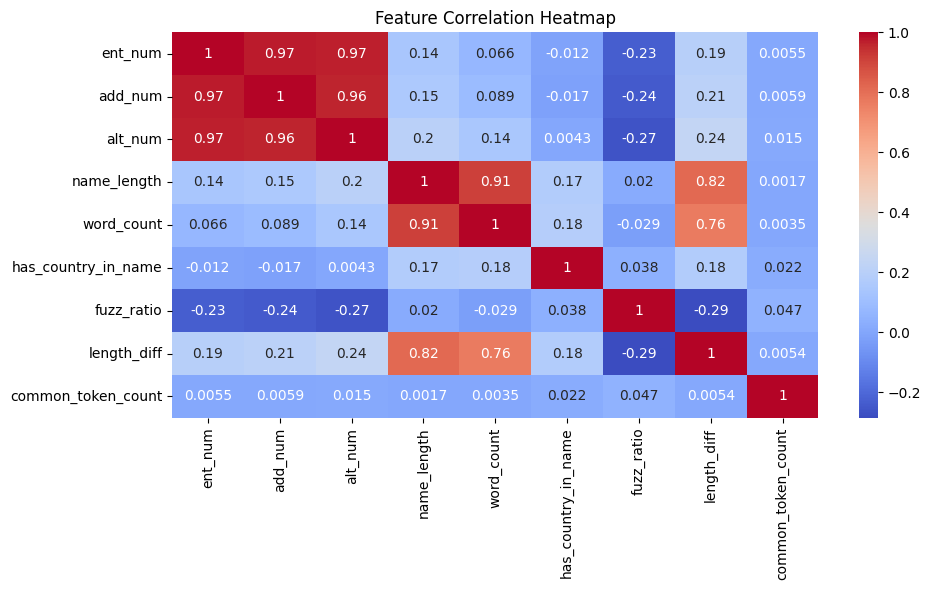

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [11]:
final_features = [
    'ent_num',
    'cleaned_name',
    'fuzz_ratio_reference',
    'name_length',
    'word_count',
    'has_country_in_name',
    'fuzz_ratio',
    'length_diff',
    'common_token_count'
]

df[final_features].to_csv('../data/sanctions_features.csv', index=False)